### Title: Cancel Culture
### Team Name: #cancelled 
Team Members: Allison DeSantis (ajd29), Klara Van Wamelen (klaravw), Sebastian Gonzalez Castro (srg4rv)

Q1: Cancel culture is the phenomenon of collectively shaming an individual (usually a celebrity or public figure) online in response to a controversial thing they said or did. Our goal is to analyze cancel culture in online communities. Is cancel culture a negative phenomenon? Are there any positive aspects? We plan to analyze this is through sentiment analysis of tweets that can be considered cancel culture tweets about a celebrity. Does being canceled significantly hurt a celebrity or public figure's following and status? We plan to analyze this is through sentiment analysis of tweets about a celebrity, comments on the celebrity's YouTube videos, and comments on the celebrity's Instagram posts. 

Allison: collected Twitter data

Klara: collected YouTube data

Sebastian: collected Instagram data

### Part 1: Twitter

In order to analyze cancel culture tweets about a celebrity, we need to collect tweets that include cancel culture language. We collected data from three incidents of cancel culture in 2019. We chose to analyze James Charles (YouTube beauty guru), Jussie Smollett (actor and singer), and Cardi B (rapper and songwriter), because these three celebrities were all canceled sometime in 2019 due to a controversial action. 

Importing necessary libraries, like GetOldTweets3 to collect tweets from 2019.

### Part 2: YouTube

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException        
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
import os
import datetime
import time
from bs4 import BeautifulSoup
import pprint
from collections import OrderedDict
import pandas as pd

In [4]:
no_of_serps = 1
search_results_path = "web_scraping"

# creating driver to scrape from
def create_driver():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--incognito")
    driver = webdriver.Chrome('/Users/klaravanwamelen/Downloads/chromedriver', options=chrome_options)
    return driver

# closing driver
def teardown_driver(driver):
    driver.quit()

# tool to check if classes exist
def check_exists_by_class(browser, class_path):
    try:
        browser.find_element_by_class_name(class_path)
        
    except NoSuchElementException:
        return False
    return True

In [34]:
# the number of scrolldowns in the search results page to get more results
scrolldown_count = 2
# time in seconds to wait till the reults load after a scrolldown
scrolldown_results_waiting_time = 4

# scraping title from youtube video
def get_video_title(soup):
    title = soup.find("h1",{'class':'title style-scope ytd-video-primary-info-renderer'})
    title = title.find("yt-formatted-string",{'class':'style-scope ytd-video-primary-info-renderer'}).get_text()
    return title

# scrapes description from youtube video
def get_description(soup):
    description = soup.find("div",{'id':'description','class':'style-scope ytd-video-secondary-info-renderer'})
    description = description.find("yt-formatted-string",{'class':'style-scope yt-formatted-string'})
    if (description is None):
        description = "NA"
    else:
        description = description.get_text()
    return description

# scrapes username from youtube video
def get_uploader_name(soup):
    name_uploader = soup.find("div",{'id':'upload-info','class':"style-scope ytd-video-owner-renderer"})
    name_uploader = name_uploader.find("a",{'class':'yt-simple-endpoint style-scope yt-formatted-string'}).get_text()
    return name_uploader

# scrapes current views from video
def get_views(soup):
    view = soup.find("span",{'class':'view-count style-scope yt-view-count-renderer'})
    if (view is None):
        view = 0
    else:
        view = view.get_text().split()[0]
    return view

# scrapes date from video
def get_date(soup):
    date = soup.find("div",{'id':'date','class':'style-scope ytd-video-primary-info-renderer'})
    date = date.find("yt-formatted-string",{'class':'style-scope ytd-video-primary-info-renderer'}).get_text()
    return date

# scrapes likes from video
def get_likes(soup):
    likes = soup.find("ytd-sentiment-bar-renderer",{'id':'sentiment','class':"style-scope ytd-video-primary-info-renderer"})
    likes = likes.find("paper-tooltip")
    likes = likes.find('div', {'id': "tooltip"}).get_text()
    likes = likes.rstrip("\n")
    likes = likes.lstrip("\n")
    return likes

#scrapes recommended videos from current video
def get_video_recommendations(soup):
#     up_next = {}
    video_recommendations = {}
    block = soup.find_all("a",{'class':'yt-simple-endpoint style-scope ytd-compact-video-renderer'})
#     up_next['title'] = block[0].find("span",{'class':'style-scope ytd-compact-video-renderer'}).get('title')
#     up_next['url'] = block[0].get('href')
    for i in range(1, len(block)):
        recommendation = {}
        recommendation['title'] = block[i].find("span",{'class':'style-scope ytd-compact-video-renderer'}).get('title')
#         recommendation['url'] = block[i].get('href')
        video_recommendations[str(i)] = recommendation
    return video_recommendations

In [4]:
def get_video_metadata(url):
    browser = create_driver()
    browser.get(url)
    time.sleep(5)
    browser.refresh()
    time.sleep(5)
    #toggle autoplay button is its pressed
    auto_play_button = browser.find_element_by_xpath("//*[@id='toggle']").get_attribute("aria-pressed")
    if auto_play_button == 'true':
        WebDriverWait(browser, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="toggle"]/div[1]'))).click()
    
    
    
    # scroll down to end of page to get more results
    html_body = browser.find_element_by_tag_name('html')
    # allows comments to load
    
    
    for i in range(0,4):
        for i in range(5):
            html_body.send_keys(Keys.ARROW_DOWN)
        time.sleep(2)
        html_body.send_keys(Keys.END)
        time.sleep(4)
        
        
    html = browser.page_source
    soup = BeautifulSoup(html, "lxml")
    
    # organizes data into data frame with each comment
    df = pd.DataFrame(columns=["Uploader","Title", "Date", "Views", "Likes/Dislikes","Comments"])
    
    i=0
    for item in browser.find_elements_by_class_name("ytd-comment-thread-renderer"):
        df.loc[i] = [get_uploader_name(soup), get_video_title(soup), get_date(soup), get_views(soup), get_likes(soup), item.text]
        i = i+1
    
    #close driver
    teardown_driver(browser)
    return df;

Scraping 3 videos from each cancel case. One before incident, one during, and one after. Date is recorded to keep track of the timeline.

In [5]:
# scraping 3 james charles videos:
james = get_video_metadata("https://www.youtube.com/watch?v=uFvtCUzfyL4")

In [6]:
# got 100 comments
james[james['Comments'].str.contains("REPLY")]

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Pinned by James Charles\nJames Charles\n11 mon...
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",rachelskyscraper\n5 months ago\nThis has got t...
6,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",` katiexvia `\n1 month ago\ncan't believe that...
9,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",pizza_lover\n1 week ago\nik this is almost a y...
12,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",colton howard\n1 month ago (edited)\nhow is th...
...,...,...,...,...,...,...
235,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Lydia Roberts\n1 day ago\nYou know it’s seriou...
237,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Jacob Brown\n1 day ago\nI like the fact that n...
239,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",onikarevenge on twitter\n1 week ago\nFunny how...
241,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",ツLTG\n3 hours ago\nJames Charles just pulled t...


In [7]:
james = james.append(get_video_metadata("https://www.youtube.com/watch?v=cxGDMR05gL0"))

In [8]:
# got 100 more comments
james[james['Comments'].str.contains("REPLY")]

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Pinned by James Charles\nJames Charles\n11 mon...
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",rachelskyscraper\n5 months ago\nThis has got t...
6,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",` katiexvia `\n1 month ago\ncan't believe that...
9,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",pizza_lover\n1 week ago\nik this is almost a y...
12,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",colton howard\n1 month ago (edited)\nhow is th...
...,...,...,...,...,...,...
215,James Charles,FALL FIRST IMPRESSIONS MAKEUP TUTORIAL,"Oct 11, 2017","1,490,505","50,554 / 1,752\n",Ishita Bagchi\n1 year ago\nWho's here after Li...
217,James Charles,FALL FIRST IMPRESSIONS MAKEUP TUTORIAL,"Oct 11, 2017","1,490,505","50,554 / 1,752\n",Kathryn Enriquez\n2 years ago\nI’m so proud of...
219,James Charles,FALL FIRST IMPRESSIONS MAKEUP TUTORIAL,"Oct 11, 2017","1,490,505","50,554 / 1,752\n",Melinda Trowbridge\n2 years ago\nLove love lov...
221,James Charles,FALL FIRST IMPRESSIONS MAKEUP TUTORIAL,"Oct 11, 2017","1,490,505","50,554 / 1,752\n",Laura and Isabella\n2 years ago\nThis look is ...


In [9]:
james = james.append(get_video_metadata("https://www.youtube.com/watch?v=eIC5YOR8gtY"))

In [10]:
# got 300!!
cleanerJames = james[james['Comments'].str.contains("REPLY")]
cleanerJames

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Pinned by James Charles\nJames Charles\n11 mon...
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",rachelskyscraper\n5 months ago\nThis has got t...
6,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",` katiexvia `\n1 month ago\ncan't believe that...
9,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",pizza_lover\n1 week ago\nik this is almost a y...
12,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",colton howard\n1 month ago (edited)\nhow is th...
...,...,...,...,...,...,...
179,James Charles,Fans Pick My Makeup On Zoom!,"Apr 21, 2020","2,034,132","146,510 / 1,794\n",alexandra pearce\n5 days ago (edited)\nwhen th...
182,James Charles,Fans Pick My Makeup On Zoom!,"Apr 21, 2020","2,034,132","146,510 / 1,794\n",Riley GameMaster\n1 day ago\nYou should do a f...
184,James Charles,Fans Pick My Makeup On Zoom!,"Apr 21, 2020","2,034,132","146,510 / 1,794\n",KittyDaWalrus :3\n1 day ago (edited)\n💖CALLING...
186,James Charles,Fans Pick My Makeup On Zoom!,"Apr 21, 2020","2,034,132","146,510 / 1,794\n",Elyana Martinez\n1 day ago\n4:06 is when he sa...


### Scraping 3 Jussie Smollett videos:

In [11]:
# got 80 comments
jussie = (get_video_metadata("https://www.youtube.com/watch?v=rkjt_pmXLQI"))
cleanerJussie = jussie[jussie['Comments'].str.contains("REPLY")]
cleanerJussie

,Uploader,Title,Date,Views,Likes/Dislikes,Comments


In [12]:
# got 80 comments again
jussie = jussie.append(get_video_metadata("https://www.youtube.com/watch?v=O2WjyxR79Bc"))
cleanerJussie = jussie[jussie['Comments'].str.contains("REPLY")]
cleanerJussie

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,PriviLegend\n1 year ago\nImagine being so safe...
3,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,NPC#5407269\n1 year ago\n“Black Lies Matter.” ...
6,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,WhatistheMatrix?\n1 year ago\nTraitor\nRace-ba...
9,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,Matt O\n1 year ago\nThis song didn’t age too w...
12,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,newgtguy\n1 year ago\nMade by one of the most ...
...,...,...,...,...,...,...
182,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,RihannaVevo c:\n2 years ago\nalmost at 1 milli...
184,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,Bran the Broker\n1 year ago\n0:59\nThere's the...
186,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,Ani Rose\n1 year ago\nThis did not age well......
188,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,annoyboyPictures\n1 year ago\nJUSSIE has a GRE...


In [13]:
# got 100 comments? maybe shorter comments filled more of the page
jussie = jussie.append(get_video_metadata("https://www.youtube.com/watch?v=Z5Mwim84XS0"))
cleanerJussie = jussie[jussie['Comments'].str.contains("REPLY")]
cleanerJussie

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,PriviLegend\n1 year ago\nImagine being so safe...
3,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,NPC#5407269\n1 year ago\n“Black Lies Matter.” ...
6,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,WhatistheMatrix?\n1 year ago\nTraitor\nRace-ba...
9,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,Matt O\n1 year ago\nThis song didn’t age too w...
12,Jussie Smollett,Jussie Smollett - F.U.W.,"Mar 15, 2017","1,242,813",,newgtguy\n1 year ago\nMade by one of the most ...
...,...,...,...,...,...,...
206,Jussie Smollett,Jussie Smollett- Catch Your Eye Ft Swizz Beatz,"Feb 9, 2018","649,418",,Jayde Lopez\n2 years ago\nThis sure amazing wa...
208,Jussie Smollett,Jussie Smollett- Catch Your Eye Ft Swizz Beatz,"Feb 9, 2018","649,418",,Daeyona Brooks\n2 years ago\nYou are my idle ❤...
210,Jussie Smollett,Jussie Smollett- Catch Your Eye Ft Swizz Beatz,"Feb 9, 2018","649,418",,arjuns_ life\n2 years ago\nKeep doin what you ...
212,Jussie Smollett,Jussie Smollett- Catch Your Eye Ft Swizz Beatz,"Feb 9, 2018","649,418",,DoomedMandy77: StormFront High Priestess\n1 ye...


### Scraping 3 Cardi B videos:

In [14]:
#got 120 comments
cardi = (get_video_metadata("https://www.youtube.com/watch?v=27z5Mu1hbJA"))
cleanerCardi = cardi[cardi['Comments'].str.contains("REPLY")]
cleanerCardi

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Nijah Fowlkes\n2 years ago\nOnly Dominican wom...
3,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Desiree Jeune\n2 years ago\nwhen she raising h...
5,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n","Sashay_ Golds\n1 year ago\n""Chill out... come ..."
7,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Privah Eliberz\n3 years ago\nA girl from bible...
9,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Alivia Whitehead\n2 years ago\n‘’TO YOUR MOTHE...
11,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",TheTrolling Unicorn cuz why not\n1 year ago (e...
13,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",meilleure amie\n1 year ago\nWHEW CHILE THE GHE...
16,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n","aibbz93\n3 years ago (edited)\n""she got that a..."
19,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",jxvkie_\n1 year ago\nLmfaoo this sounded like ...
21,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",MissManny killuminatti\n3 years ago (edited)\n...


In [15]:
# got 135 comments
cardi = cardi.append(get_video_metadata("https://www.youtube.com/watch?v=xTlNMmZKwpA"))
cleanerCardi = cardi[cardi['Comments'].str.contains("REPLY")]
cleanerCardi

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Nijah Fowlkes\n2 years ago\nOnly Dominican wom...
3,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Desiree Jeune\n2 years ago\nwhen she raising h...
5,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n","Sashay_ Golds\n1 year ago\n""Chill out... come ..."
7,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Privah Eliberz\n3 years ago\nA girl from bible...
9,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Alivia Whitehead\n2 years ago\n‘’TO YOUR MOTHE...
...,...,...,...,...,...,...
234,Cardi B,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...","May 29, 2018","1,127,572,997","7,449,697 / 482,513\n","Danny Boi\n2 weeks ago\nGuerrero como Eddie, V..."
236,Cardi B,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...","May 29, 2018","1,127,572,997","7,449,697 / 482,513\n",MaZarek Cogdell\n1 week ago\nCardi: I LIKE IT ...
238,Cardi B,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...","May 29, 2018","1,127,572,997","7,449,697 / 482,513\n",Leca Capella\n12 hours ago (edited)\nEssa mulh...
240,Cardi B,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...","May 29, 2018","1,127,572,997","7,449,697 / 482,513\n",Ethan Moo\n1 month ago\nThis song makes me fee...


In [16]:
#got 100 comments
cardi = cardi.append(get_video_metadata("https://www.youtube.com/watch?v=cJc7xWJbwJw"))
cleanerCardi = cardi[cardi['Comments'].str.contains("REPLY")]
cleanerCardi

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Nijah Fowlkes\n2 years ago\nOnly Dominican wom...
3,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Desiree Jeune\n2 years ago\nwhen she raising h...
5,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n","Sashay_ Golds\n1 year ago\n""Chill out... come ..."
7,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Privah Eliberz\n3 years ago\nA girl from bible...
9,Cardi B,Cardi B - Leave That Bitch Alone (Skit) (Audio...,"Jan 20, 2017","151,898","1,645 / 155\n",Alivia Whitehead\n2 years ago\n‘’TO YOUR MOTHE...
...,...,...,...,...,...,...
181,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Brianna Lynne\n9 months ago (edited)\nYouTube:...
184,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",K0 K0\n1 day ago\nKilled it 🔥\n1\nREPLY
186,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Cesco 00\n1 day ago\n2:04 If Annalise Keating ...
188,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Eliza\n3 weeks ago\nAh ok I kinda expected tha...


### merging all artists to one dataframe

In [115]:
df = cleanerJames.append(cleanerJussie.append(cleanerCardi))
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",Pinned by James Charles\nJames Charles\n11 mon...
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",rachelskyscraper\n5 months ago\nThis has got t...
6,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",` katiexvia `\n1 month ago\ncan't believe that...
9,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",pizza_lover\n1 week ago\nik this is almost a y...
12,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400\n",colton howard\n1 month ago (edited)\nhow is th...
...,...,...,...,...,...,...
181,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Brianna Lynne\n9 months ago (edited)\nYouTube:...
184,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",K0 K0\n1 day ago\nKilled it 🔥\n1\nREPLY
186,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Cesco 00\n1 day ago\n2:04 If Annalise Keating ...
188,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913\n",Eliza\n3 weeks ago\nAh ok I kinda expected tha...


Cleaning newline character from likes/dislikes ratio

In [116]:
df["Likes/Dislikes"] = df["Likes/Dislikes"].replace('\n','', regex=True)
# reset index and dropping James comment on own video
df = df.iloc[1:,:]
df = df.reset_index().drop_duplicates( keep='last')
#dropping old index column
df = df.iloc[:,1:]
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comments
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",rachelskyscraper\n5 months ago\nThis has got t...
1,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",` katiexvia `\n1 month ago\ncan't believe that...
2,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",pizza_lover\n1 week ago\nik this is almost a y...
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",colton howard\n1 month ago (edited)\nhow is th...
4,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",The tea Is hot\n3 weeks ago\nThe fact that thi...
...,...,...,...,...,...,...
690,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Brianna Lynne\n9 months ago (edited)\nYouTube:...
691,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",K0 K0\n1 day ago\nKilled it 🔥\n1\nREPLY
692,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Cesco 00\n1 day ago\n2:04 If Annalise Keating ...
693,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Eliza\n3 weeks ago\nAh ok I kinda expected tha...


### Breaking comments column into respective parts

In [117]:
def splitMultiple(mickle):
    data = mickle.split('\n')
    info = []
    info.append(data[0])
    info.append(data [1])
    comment = ""
    for line in data[2:-2]:
        comment+=line+'\n'
    info.append(comment)
    info.append(data[-2])
    if info[2] == "":
        info[2]=info[3]
        info[3] =0
    return info

In [118]:
l=pd.DataFrame(list(df.Comments.map(splitMultiple)), columns=['Comment_User','Comment_Date','Comment','Comment_Likes'])
l

,Comment_User,Comment_Date,Comment,Comment_Likes
0,rachelskyscraper,5 months ago,This has got to be the biggest uno reverse car...,36K
1,` katiexvia `,1 month ago,can't believe that James literally handled thi...,12K
2,pizza_lover,1 week ago,"ik this is almost a year old, but James, serio...",1.3K
3,colton howard,1 month ago (edited),how is this 11 months ago it literally feels l...,4.8K
4,The tea Is hot,3 weeks ago,The fact that this video didn’t have a single ...,1.1K
...,...,...,...,...
690,Brianna Lynne,9 months ago (edited),YouTube: No sexual related/nudity permitted. \...,2.5K
691,K0 K0,1 day ago,Killed it 🔥\n,1
692,Cesco 00,1 day ago,2:04 If Annalise Keating were a rapper.,0
693,Eliza,3 weeks ago,Ah ok I kinda expected that from Cardi\n,1


### Replacing old comments column with new comment detail colums

In [119]:
df = pd.concat([df.iloc[:,:-1],l], axis=1)
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comment_User,Comment_Date,Comment,Comment_Likes
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",rachelskyscraper,5 months ago,This has got to be the biggest uno reverse car...,36K
1,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",` katiexvia `,1 month ago,can't believe that James literally handled thi...,12K
2,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",pizza_lover,1 week ago,"ik this is almost a year old, but James, serio...",1.3K
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",colton howard,1 month ago (edited),how is this 11 months ago it literally feels l...,4.8K
4,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",The tea Is hot,3 weeks ago,The fact that this video didn’t have a single ...,1.1K
...,...,...,...,...,...,...,...,...,...
690,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Brianna Lynne,9 months ago (edited),YouTube: No sexual related/nudity permitted. \...,2.5K
691,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",K0 K0,1 day ago,Killed it 🔥\n,1
692,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Cesco 00,1 day ago,2:04 If Annalise Keating were a rapper.,0
693,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Eliza,3 weeks ago,Ah ok I kinda expected that from Cardi\n,1


In [120]:
import datetime
from dateutil.relativedelta import relativedelta

def get_past_date(str_days_ago):
    TODAY = datetime.date.today()
    splitted = str_days_ago.split()
    if len(splitted) == 1 and splitted[0].lower() == 'today':
        return str(TODAY.isoformat())
    elif len(splitted) == 1 and splitted[0].lower() == 'yesterday':
        date = TODAY - relativedelta(days=1)
        return str(date.isoformat())
    elif splitted[1].lower() in ['hour', 'hours', 'hr', 'hrs', 'h']:
        date = datetime.datetime.now() - relativedelta(hours=int(splitted[0]))
        return str(date.date().isoformat())
    elif splitted[1].lower() in ['day', 'days', 'd']:
        date = TODAY - relativedelta(days=int(splitted[0]))
        return str(date.isoformat())
    elif splitted[1].lower() in ['wk', 'wks', 'week', 'weeks', 'w']:
        date = TODAY - relativedelta(weeks=int(splitted[0]))
        return str(date.isoformat())
    elif splitted[1].lower() in ['mon', 'mons', 'month', 'months', 'm']:
        date = TODAY - relativedelta(months=int(splitted[0]))
        return str(date.isoformat())
    elif splitted[1].lower() in ['yrs', 'yr', 'years', 'year', 'y']:
        date = TODAY - relativedelta(years=int(splitted[0]))
        return str(date.isoformat())
    else:
        return str(TODAY.isoformat())

### Fixing comment_date

In [121]:
df.Comment_Date=df.Comment_Date.map(get_past_date)
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comment_User,Comment_Date,Comment,Comment_Likes
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",rachelskyscraper,2019-11-28,This has got to be the biggest uno reverse car...,36K
1,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",` katiexvia `,2020-03-28,can't believe that James literally handled thi...,12K
2,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",pizza_lover,2020-04-21,"ik this is almost a year old, but James, serio...",1.3K
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",colton howard,2020-03-28,how is this 11 months ago it literally feels l...,4.8K
4,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",The tea Is hot,2020-04-07,The fact that this video didn’t have a single ...,1.1K
...,...,...,...,...,...,...,...,...,...
690,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Brianna Lynne,2019-07-28,YouTube: No sexual related/nudity permitted. \...,2.5K
691,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",K0 K0,2020-04-27,Killed it 🔥\n,1
692,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Cesco 00,2020-04-27,2:04 If Annalise Keating were a rapper.,0
693,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Eliza,2020-04-07,Ah ok I kinda expected that from Cardi\n,1


### fixing comment_likes

In [122]:
def to_thousands(likes):
    if type(likes) is str:
        if "www.youtube.com" in likes:
            return 0
        if "K" in likes:
            a = likes.replace("K","")
            temp = 1000*float(a)
            return int(temp)
    return likes

In [123]:
df.Comment_Likes=df.Comment_Likes.map(to_thousands)
df.Comment_Likes = pd.to_numeric(df.Comment_Likes,errors='coerce')
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comment_User,Comment_Date,Comment,Comment_Likes
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",rachelskyscraper,2019-11-28,This has got to be the biggest uno reverse car...,36000.0
1,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",` katiexvia `,2020-03-28,can't believe that James literally handled thi...,12000.0
2,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",pizza_lover,2020-04-21,"ik this is almost a year old, but James, serio...",1300.0
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",colton howard,2020-03-28,how is this 11 months ago it literally feels l...,4800.0
4,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",The tea Is hot,2020-04-07,The fact that this video didn’t have a single ...,1100.0
...,...,...,...,...,...,...,...,...,...
690,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Brianna Lynne,2019-07-28,YouTube: No sexual related/nudity permitted. \...,2500.0
691,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",K0 K0,2020-04-27,Killed it 🔥\n,1.0
692,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Cesco 00,2020-04-27,2:04 If Annalise Keating were a rapper.,0.0
693,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Eliza,2020-04-07,Ah ok I kinda expected that from Cardi\n,1.0


In [104]:
df.to_csv('betterYoutube.csv')

# James Charles Analysis

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn

Setting up vader analysis

In [140]:
df = pd.read_csv('betterYoutube.csv')
analyzer = SentimentIntensityAnalyzer()
sentences = df.Comment.tolist()
vs = []
for sentence in sentences:
    vs.append(analyzer.polarity_scores(sentence))
df = df.iloc[:,2:]
df

,Uploader,Title,Date,Views,Likes/Dislikes,Comment_User,Comment_Date,Comment,Comment_Likes
0,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",rachelskyscraper,2019-11-28,This has got to be the biggest uno reverse car...,36000.0
1,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",` katiexvia `,2020-03-28,can't believe that James literally handled thi...,12000.0
2,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",pizza_lover,2020-04-21,"ik this is almost a year old, but James, serio...",1300.0
3,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",colton howard,2020-03-28,how is this 11 months ago it literally feels l...,4800.0
4,James Charles,No More Lies,"May 18, 2019","49,867,732","2,456,577 / 610,400",The tea Is hot,2020-04-07,The fact that this video didn’t have a single ...,1100.0
...,...,...,...,...,...,...,...,...,...
690,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Brianna Lynne,2019-07-28,YouTube: No sexual related/nudity permitted. \...,2500.0
691,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",K0 K0,2020-04-27,Killed it 🔥\n,1.0
692,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Cesco 00,2020-04-27,2:04 If Annalise Keating were a rapper.,0.0
693,Cardi B,Cardi B - Press [Official Music Video],"Premiered Jun 26, 2019","70,298,597","1,501,301 / 153,913",Eliza,2020-04-07,Ah ok I kinda expected that from Cardi\n,1.0


In [141]:
vader = pd.DataFrame(vs)

In [142]:
analysisdf = pd.concat([df,vader], axis=1)
analysisdf
James = analysisdf.loc[analysisdf['Uploader'] == "James Charles"]
Cardi = analysisdf.loc[analysisdf['Uploader'] == "Cardi B"]

In [143]:
James_before = analysisdf.loc[analysisdf['Title'] == "FALL FIRST IMPRESSIONS MAKEUP TUTORIAL"]
James_during = analysisdf.loc[analysisdf['Title'] == "No More Lies"]
James_after = analysisdf.loc[analysisdf['Title'] == "Fans Pick My Makeup On Zoom!"]

Getting likes, dislikes, and views ready for plots

In [144]:
James_before_ratio = James_before.iloc[1,4].split("/")
James_during_ratio = James_during.iloc[1,4].split("/")
James_after_ratio = James_after.iloc[1,4].split("/")

James_likes = [int(James_before_ratio[0].replace(" ","").replace(",","")),int(James_during_ratio[0].replace(" ","").replace(",","")),int(James_after_ratio[0].replace(" ","").replace(",",""))]
James_dislikes = [int(James_before_ratio[1].replace(" ","").replace(",","")),int(James_during_ratio[1].replace(" ","").replace(",","")),int(James_after_ratio[1].replace(" ","").replace(",",""))]

James_views = [int(James_before.iloc[1,3].replace(",","")), int(James_during.iloc[1,3].replace(",","")),int(James_after.iloc[1,3].replace(",",""))]

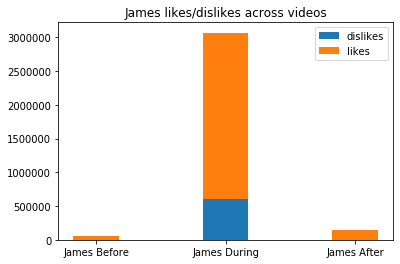

In [145]:
fig, ax = plt.subplots()

labels = ['James Before','James During','James After']

ax.bar(labels, James_dislikes, .35, label='dislikes')
ax.bar(labels, James_likes, .35, bottom=James_dislikes, label='likes')

ax.set_title('James likes/dislikes across videos')
ax.legend()

plt.show()

#### This stacked bar plot shows the engagement in James Charles videos went way up during his cancel controversy, yet he still had proportionally more likes

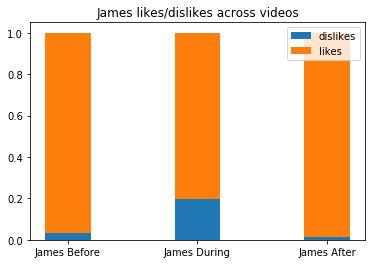

In [146]:
totallikesbefore = James_dislikes[0]+James_likes[0]
totallikesduring = James_dislikes[1]+James_likes[1]
totallikesafter = James_dislikes[2]+James_likes[2]
total = [totallikesbefore,totallikesduring,totallikesafter]

dis= [James_dislikes[x]/total[x] for x in range(3)]
lik=[James_likes[x]/total[x] for x in range(3)]

fig, ax1 = plt.subplots()

labels = ['James Before','James During','James After']

ax1.bar(labels, dis, .35, label='dislikes')
ax1.bar(labels, lik, .35, bottom=dis,label='likes')

ax1.set_title('James likes/dislikes across videos')
ax1.legend()

plt.show()

#### Looking now at a stacked proportional barplots we see that James dislikes ratio went up slightly during his cancel event (20% dislikes) but went back to how it was before after

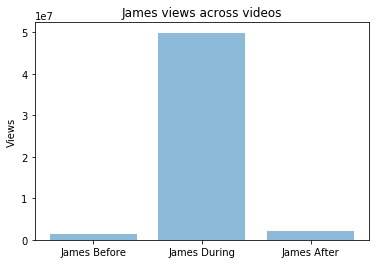

In [147]:
plt.bar(labels, James_views, align='center', alpha=0.5)
plt.xticks(labels)
plt.ylabel('Views')
plt.title('James views across videos')

plt.show()

#### This bar plot shows that the views during James controversy skyrocketed up to almost 50 million, and again restabalized after. This shows that the controversey did not have a substantial effect on his overall views positively or negatively.

## Sentiment analysis:

In [148]:
James_before["compound"].mean()

0.45961299999999994

In [149]:
James_during["compound"].mean()

0.09915757575757576

In [150]:
James_after["compound"].mean()

0.30840249999999997

#### These means above show that James overall sentiment went down to .09 in the comments during his controversy. They also show that his sentiment after the controversy in the comments remained lower than before.

/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(array([736700., 736800., 736900., 737000., 737100., 737200., 737300.,
        737400., 737500., 737600.]), <a list of 10 Text xticklabel objects>)

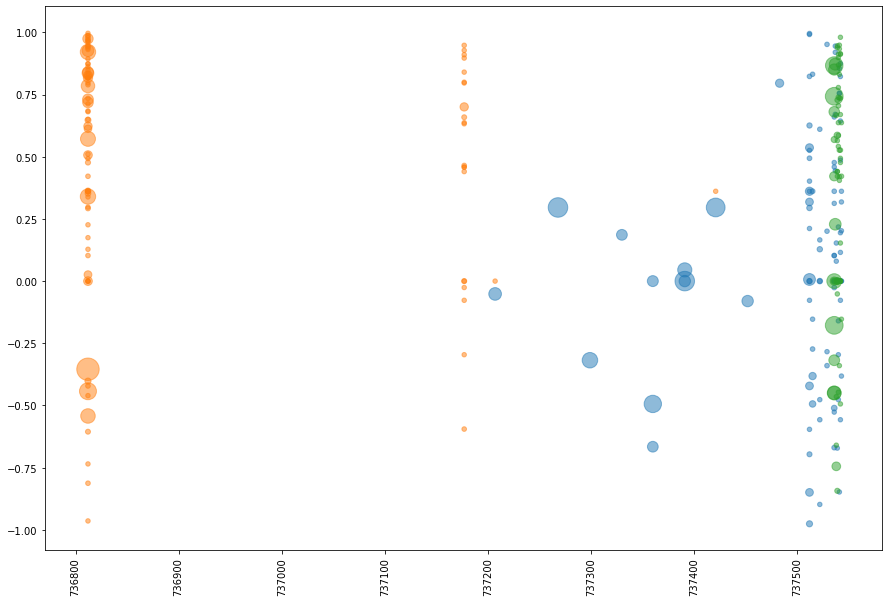

In [151]:
James_before['date_ordinal'] = pd.to_datetime(James_before['Comment_Date']).apply(lambda date: date.toordinal())
James_during['date_ordinal'] = pd.to_datetime(James_during['Comment_Date']).apply(lambda date: date.toordinal())
James_after['date_ordinal'] = pd.to_datetime(James_after['Comment_Date']).apply(lambda date: date.toordinal())

plt.figure(figsize=(15,10))
size1=(James_during["Comment_Likes"]/(James_during["Comment_Likes"].mean()))*30+20
plt.scatter(James_during["date_ordinal"], James_during["compound"], s=size1, alpha=0.5)
size2=(James_before["Comment_Likes"]/(James_before["Comment_Likes"].mean()))*30+20
plt.scatter(James_before["date_ordinal"], James_before["compound"], s=size2, alpha=0.5)
size3=(James_after["Comment_Likes"]/(James_after["Comment_Likes"].mean()))*30+20
plt.scatter(James_after["date_ordinal"], James_after["compound"], s=size3, alpha=0.5)
plt.xticks(rotation=90)

#### The above scatter plot has distinct vertical lines due to the web scraping on YouTube giving only increments such as a month ago or a year ago as the dates of the comments. Darker areas show where the sentiment on the comments were more densely concentrated such as after his controversy (the green) although his mean sentiment went down.

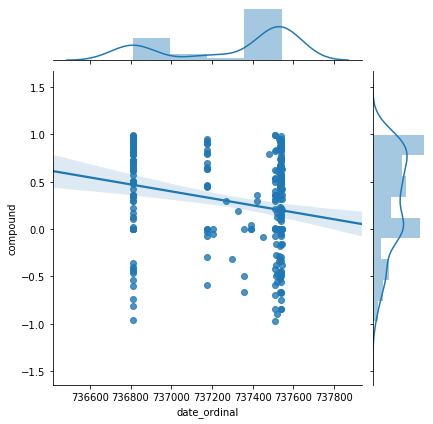

In [153]:
seaborn.jointplot(x='date_ordinal', y='compound',kind="reg",data=James)

#### Finally, this joint plot shows both the regression from before as well as the distributions of comments over time and sentiment. It shows that over all the of these videos James has a mostly right-skew on his sentiment (more positive) but a big spike right below the neutral.

# Cardi Analysis

In [154]:
Cardi_before = analysisdf.loc[analysisdf['Title'] == "Cardi B - Leave That Bitch Alone (Skit) (Audio) ft. Justvlad"]
Cardi_during = analysisdf.loc[analysisdf['Title'] == "Cardi B, Bad Bunny & J Balvin - I Like It [Official Music Video]"]
Cardi_after = analysisdf.loc[analysisdf['Title'] == "Cardi B - Press [Official Music Video]"]

Setting up likes, dislikes, and views for bar plots

In [155]:
Cardi_before_ratio = Cardi_before.iloc[1,4].split("/")
Cardi_during_ratio = Cardi_during.iloc[1,4].split("/")
Cardi_after_ratio = Cardi_after.iloc[1,4].split("/")

Cardi_likes = [int(Cardi_before_ratio[0].replace(" ","").replace(",","")),\
               int(Cardi_during_ratio[0].replace(" ","").replace(",","")),\
               int(Cardi_after_ratio[0].replace(" ","").replace(",",""))]

Cardi_dislikes = [int(Cardi_before_ratio[1].replace(" ","").replace(",","")),\
                  int(Cardi_during_ratio[1].replace(" ","").replace(",","")),\
                  int(Cardi_after_ratio[1].replace(" ","").replace(",",""))]

Cardi_views = [int(Cardi_before.iloc[1,3].replace(",","")),\
               int(Cardi_during.iloc[1,3].replace(",","")),\
               int(Cardi_after.iloc[1,3].replace(",",""))]

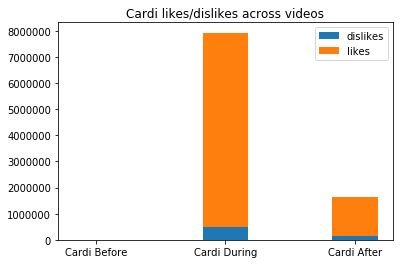

In [156]:
fig, ax = plt.subplots()

labels = ['Cardi Before','Cardi During','Cardi After']

ax.bar(labels, Cardi_dislikes, .35, label='dislikes')
ax.bar(labels, Cardi_likes, .35, bottom=Cardi_dislikes, label='likes')

ax.set_title('Cardi likes/dislikes across videos')
ax.legend()

plt.show()

In [157]:
Cardi_before_ratio

['      1,645 ', ' 155    ']

#### This stacked barplot of likes/dislikes on Cardi's videos is not very effective due to her video during her controversy reaching 1.1 billion views. It completely shrinks her likes/comments from before. This could also be just her natural rise to fame. I've printed her likes/dislikes before.

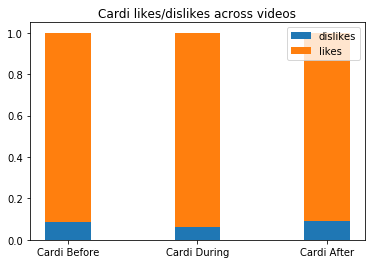

In [158]:
totallikesbefore = Cardi_dislikes[0]+Cardi_likes[0]
totallikesduring = Cardi_dislikes[1]+Cardi_likes[1]
totallikesafter = Cardi_dislikes[2]+Cardi_likes[2]
total = [totallikesbefore,totallikesduring,totallikesafter]

dis= [Cardi_dislikes[x]/total[x] for x in range(3)]
lik=[Cardi_likes[x]/total[x] for x in range(3)]

fig, ax1 = plt.subplots()

labels = ['Cardi Before','Cardi During','Cardi After']

ax1.bar(labels, dis, .35, label='dislikes')
ax1.bar(labels, lik, .35, bottom=dis,label='likes')

ax1.set_title('Cardi likes/dislikes across videos')
ax1.legend()

plt.show()

#### A proportional barplot better shows that Cardi's like/dislikes ratio were not affected by her controversy.

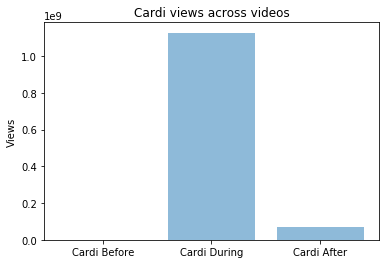

In [159]:
plt.bar(labels, Cardi_views, align='center', alpha=0.5)
plt.xticks(labels)
plt.ylabel('Views')
plt.title('Cardi views across videos')

plt.show()

#### This barplot of her views show the extreme change in views from her popular song

## Sentiment analysis:

In [160]:
Cardi_before["compound"].mean()

0.23808813559322034

In [161]:
Cardi_during["compound"].mean()

0.15618969072164945

In [162]:
Cardi_after["compound"].mean()

0.06415874999999999

#### These means show Cardi's sentiment in the comments only went down a little due to her controversy and went above after.

/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/klaravanwamelen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(array([736200., 736400., 736600., 736800., 737000., 737200., 737400.,
        737600., 737800.]), <a list of 9 Text xticklabel objects>)

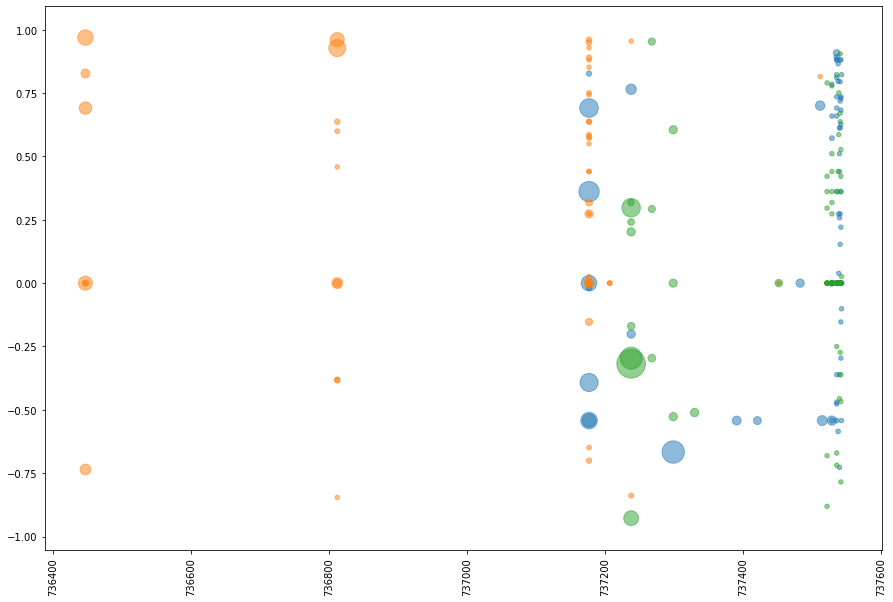

In [163]:
Cardi_before['date_ordinal'] = pd.to_datetime(Cardi_before['Comment_Date']).apply(lambda date: date.toordinal())
Cardi_during['date_ordinal'] = pd.to_datetime(Cardi_during['Comment_Date']).apply(lambda date: date.toordinal())
Cardi_after['date_ordinal'] = pd.to_datetime(Cardi_after['Comment_Date']).apply(lambda date: date.toordinal())

plt.figure(figsize=(15,10))
size=(Cardi_during["Comment_Likes"]/(Cardi_during["Comment_Likes"].mean()))*30+20
plt.scatter(Cardi_during["date_ordinal"], Cardi_during["compound"], s=size,alpha=0.5)
size2=(Cardi_before["Comment_Likes"]/(Cardi_before["Comment_Likes"].mean()))*30+20
plt.scatter(Cardi_before["date_ordinal"], Cardi_before["compound"], s=size2, alpha=0.5)
size3=(Cardi_after["Comment_Likes"]/(Cardi_after["Comment_Likes"].mean()))*30+20
plt.scatter(Cardi_after["date_ordinal"], Cardi_after["compound"], s=size3, alpha=0.5)
plt.xticks(rotation=90)

#### Again, the above scatter plot shows the sentiment of the comments on each video organized by color. Darker areas show where the sentiment on the comments were more densely concentrated. It's not clear looking at this graph whether her sentiment went up or down

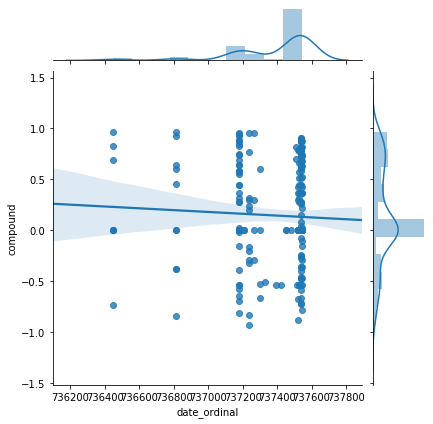

In [166]:
seaborn.jointplot(x='date_ordinal', y='compound',kind="reg",data=Cardi)

#### Finally, this plot adds the comment and sentiment distibutions to the previous graph. It shows that although her overall sentiment is fairly centered, there is a peak below neutral.

## Analyzing one more thing on James Charles

#### Lastly, I wanted to look into the recommended videos on James Charles throughout his controversy. I thought this would be useful to see how YouTube's algorithm reflects controversy on it's platform. 

In [167]:
def get_new_video_metadata(url):
    browser = create_driver()
    browser.get(url)
    time.sleep(5)
    #toggle autoplay button is its pressed
    auto_play_button = browser.find_element_by_xpath("//*[@id='toggle']").get_attribute("aria-pressed")
    if auto_play_button == 'true':
        WebDriverWait(browser, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="toggle"]/div[1]'))).click()
    
    
    
    # scroll down to end of page to get more results
    html_body = browser.find_element_by_tag_name('html')
    # allows comments to load
    
    for i in range(7):
        for i in range(30):
            html_body.send_keys(Keys.ARROW_DOWN)
        time.sleep(2)
        
        
    html = browser.page_source
    soup = BeautifulSoup(html, "lxml")
    
    videoRecs = get_video_recommendations(soup)
    
#     # organizes data into data frame with each comment
#     df = pd.DataFrame(columns=["Uploader","Title", "Date", "Views", "Likes/Dislikes","Comments"])
    
#     i=0
#     for item in browser.find_elements_by_class_name("ytd-comment-thread-renderer"):
#         df.loc[i] = [get_uploader_name(soup), get_video_title(soup), get_date(soup), get_views(soup), get_likes(soup), item.text]
#         i = i+1
    
    #close driver
    teardown_driver(browser)
    return videoRecs

In [ ]:
jamesRecBefore = get_new_video_metadata("https://www.youtube.com/watch?v=cxGDMR05gL0")

In [209]:
recT = pd.DataFrame(jamesRecBefore)
rec = recT.T

analyzer = SentimentIntensityAnalyzer()
sentences = rec.title.tolist()
vs = []
for sentence in sentences:
    vs.append(analyzer.polarity_scores(sentence))

vader = pd.DataFrame(vs)

recBeforeAnalysis = pd.concat([rec.reset_index(drop=True),vader.reset_index(drop=True)], axis=1)
recBeforeAnalysis.head()

,title,neg,neu,pos,compound
0,MORPHE HOLIDAY COLLECTION FULL REVEAL & TUTORIAL,0.0,0.636,0.364,0.5319
1,$50 MAKEOVER vs. $3000 MAKEOVER,0.0,1.000,0.000,0.0000
2,The Competition Begins - Instant Influencer,0.0,1.000,0.000,0.0000
3,TESTING KYLIE $360 BRUSH SET VS MORPHE DUPES,0.0,1.000,0.000,0.0000
4,LITTLE BROTHER BUYS MY MAKEUP,0.0,1.000,0.000,0.0000


In [207]:
recBeforeAnalysis["compound"].mean()

0.07281206896551726

In [168]:
jamesRecDuring = get_new_video_metadata("https://www.youtube.com/watch?v=uFvtCUzfyL4")

In [211]:
recT = pd.DataFrame(jamesRecDuring)
rec = recT.T

analyzer = SentimentIntensityAnalyzer()
sentences = rec.title.tolist()
vs = []
for sentence in sentences:
    vs.append(analyzer.polarity_scores(sentence))
vader = pd.DataFrame(vs)

recDuringAnalysis = pd.concat([rec.reset_index(drop=True),vader.reset_index(drop=True)], axis=1)
recDuringAnalysis.head()

,title,neg,neu,pos,compound
0,DMing Celebrities To Pick My Makeup,0.000,1.000,0.000,0.0000
1,We Finally Get The James Charles And Tati West...,0.000,1.000,0.000,0.0000
2,"Billie Eilish: Same Interview, The Third Year ...",0.156,0.656,0.189,0.1027
3,Click and Drag - Instant Influencer,0.275,0.725,0.000,-0.2263
4,Kylie Jenner: A Day in the Life,0.000,1.000,0.000,0.0000


In [179]:
recDuringAnalysis["compound"].mean()

0.01925344827586207

In [196]:
jamesRecAfter = get_new_video_metadata("https://www.youtube.com/watch?v=eIC5YOR8gtY")

In [210]:
recT = pd.DataFrame(jamesRecAfter)

rec = recT.T
rec

analyzer = SentimentIntensityAnalyzer()
sentences = rec.title.tolist()
vs = []
for sentence in sentences:
    vs.append(analyzer.polarity_scores(sentence))

vader = pd.DataFrame(vs)

recAfterAnalysis = pd.concat([rec.reset_index(drop=True),vader.reset_index(drop=True)], axis=1)
recAfterAnalysis.head()

,title,neg,neu,pos,compound
0,Hate Comments Do My Makeup,0.481,0.519,0.0,-0.5719
1,DMing Celebrities To Pick My Makeup,0.000,1.000,0.0,0.0000
2,Strangers On Omegle Pick My Makeup!,0.000,1.000,0.0,0.0000
3,Instagram Filters CHOOSE MY MAKEUP! | NikkieTu...,0.000,1.000,0.0,0.0000
4,How I Used To Do My Makeup vs. Now,0.000,1.000,0.0,0.0000


In [199]:
recAfterAnalysis["compound"].mean()

-0.04530128205128205

#### As you can see the overall sentiment of the videos getting recommened against James Charles reflect the sentiment in the comments:

In [201]:
recBeforeAnalysis["compound"].mean()

0.07281206896551726

In [214]:
James_before["compound"].mean()

0.45961299999999994

In [200]:
recDuringAnalysis["compound"].mean()

0.01925344827586207

In [213]:
James_during["compound"].mean()

0.09915757575757576

In [202]:
recAfterAnalysis["compound"].mean()

-0.04530128205128205

In [212]:
James_after["compound"].mean()

0.30840249999999997

#### Interestingly we see that video recommendations have a lasting negative effect even well after his controversy

# Conclusions

#### Analysis of the YouTube data informed more about the process than research questions
YouTube is not as strong of a source for cancel culture data when a user’s channel is less personality based (Cardi B is just music videos)
Web scraping does not give good data points due to exact comment dates not being displayed on the web page


### Is cancel culture a negative phenomenon? Are there any positive aspects?

#### Overall, these two cases of James Charles and Cardi B show that overall negative sentiment in the comments increased over time and the celebrities were negatively impacted

### The Does being “canceled” on social media significantly hurt a celebrity or public figure’s following or status? 

#### The YouTube recommendations on James Charles videos showed that the algorithm will likely recommend more negative videos after a controversy, further hurting a celebrities following. This can put the celebirty in a negative feedback loop and potentally have long-term negative effects on their image.